# Assignment 1
## Part 1 (Evaluating RBF Kernels)
- Firstly, we extend the `rbf_evaluation_cuda` function to deal with larger numbers of sources. To achieve this goal, a new threadblock layout needs to be created. We create threadblocks of size **16 x 32** which are responsible for 16 targets and 32 sources. Each threadblock now evaluates its own local result. Therefore, we need to create a grid of `(l,p)` thread blocks with `l=(m+15)/16 and p=(n+31)/32`. Here **m** is the number of targets and **n** is the number of resources.

- At the same time, we need to modify the original function  `rbf_evaluation_cuda` to accommodate the new threadblock layout. An obvious change is that we add a new parameter `device_interm_result` to this function to store the intermediate results, and the size of `device_interm_result` is `(m,p)`.

 

In [1]:
import numpy as np
import numba
from numba import cuda
import math
import gc

sigma = .1

# size of threadblocks
SX = 16
SY = 32


@cuda.jit
def rbf_evaluation_cuda(sources, targets, weights,device_interm_result):
    local_result = cuda.shared.array((SX, SY), numba.float32)
    local_targets = cuda.shared.array((SX, 3), numba.float32)
    local_sources = cuda.shared.array((SY, 3), numba.float32)
    local_weights = cuda.shared.array(SY, numba.float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
    
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[py]
        
    
    cuda.syncthreads()
    
    # Now compute the interactions
    squared_diff = numba.float32(0)
    
    for index in range(3):
        squared_diff += (local_targets[tx, index] - local_sources[ty, index])**2
    local_result[tx, ty] = math.exp(-squared_diff / ( numba.float32(2) * numba.float32(sigma)**2)) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results and store the sum into intermediate result
    by = cuda.blockIdx.y 
    
    if ty == 0 :
        res = numba.float32(0)
        for index in range(SY):
            res += local_result[tx, index]
        device_interm_result[px,by]=res 



Then create a summation kernel of m threads, where each thread sums up the p numbers in its row of the intermediate array (m, p) and store into the result array `device_result` of dimension m.

In [2]:
@cuda.jit
def summation_kernel(device_interm_result,device_result):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    px, py = cuda.grid(2)

    if px >= device_interm_result.shape[0]:
        return

    # sum up numbers in device_interm_result
    if ty == 0:
        res = numba.float32(0)
        for index in range(device_interm_result.shape[1]):
            res += device_interm_result[px, index]
        device_result[px] =res
    

Create visualization functions as in the lecture notes

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["font.size"] = 16


def visualize(result, npoints):
    """A helper function for visualization"""
    
    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T
    #print('---------result_xy-------------')
    #print(result_xy[45:50,45:50])
    fig = plt.figure(figsize=(20, 20))    

    ax = fig.add_subplot(1, 3, 1)   
    im = ax.imshow(result_xy, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)   
    im = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)   
    im = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')


Create a function to generate the data, including targets, sources and weights.

In [4]:
def data_generator(npoints,nsources):

    plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]
    targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
    targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
    targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

    targets = np.vstack((targets_xy, targets_xz, targets_yz))

    rand = np.random.RandomState(0)

    # We are picking random sources
    sources = rand.rand(nsources, 3)
    weights = rand.rand(len(sources))


    return targets,sources,weights

Define a simple convenient timer.

In [5]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

**Now we will take the following steps:**
- Use the CUDA memory transfer functions to copy the sources and targets to the compute device.

- On the compute device create an array for the intermediate results that is of size (m, p).

- Launch threadblocks that evaluate the partial sum for 16 targets and 32 sources at a time and store the results in the corresponding part of the (m, p) array.

- Then launch a summation kernel of m threads, where each thread sums up the p numbers in its row of the intermediate array (m, p) and store into a result array of dimension m.

- Finally, copy the end result back to the CPU and return to the user.



transfer from the CPU to the GPU time:  0.18695354461669922 s
execution time:  0.839674711227417 s
transfer back time:  0.0010056495666503906 s


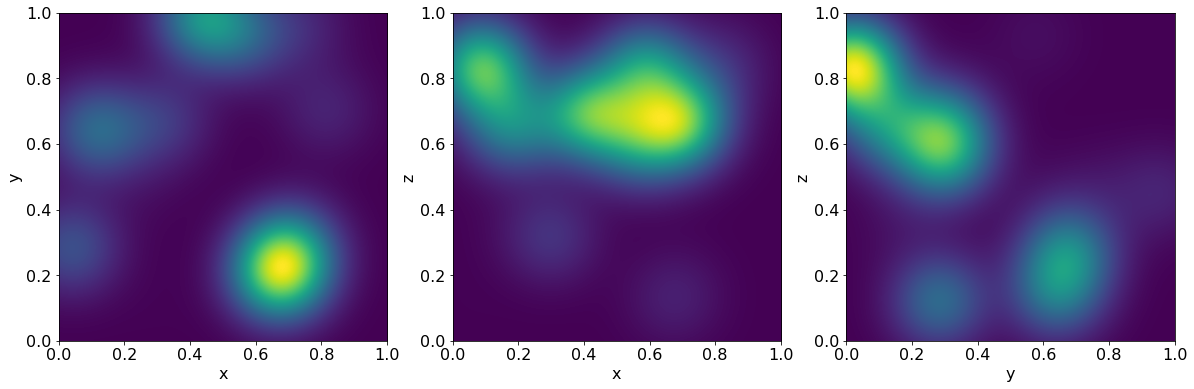

In [6]:
# clear GPU memory
gc.collect()

npoints =400
nsources = 50 # sources n

# generate targets,sources,weights and transfer these data to device
targets,sources,weights=data_generator(npoints,nsources)

# compute blocks per grid
l=(targets.shape[0]+SX-1)//SX
p=(nsources+SY-1)//SY

# memory transfers from the CPU to the GPU
with Timer() as t:
    device_targets=numba.cuda.to_device(targets.astype('float32'))
    device_sources=numba.cuda.to_device(sources.astype('float32'))
    device_weights=numba.cuda.to_device(weights.astype('float32'))
    # create the device arrays 
    device_interm_result = numba.cuda.device_array((targets.shape[0],p), dtype=np.float32) #intermediate array of size (m, p).
    device_result=numba.cuda.device_array(targets.shape[0], dtype=np.float32) 
print('transfer from the CPU to the GPU time: ', t.interval,'s')



with Timer() as t:
    #Launch threadblocks that evaluate the partial sum for 16 targets and 32 sources at a time 
    #and store the results in the corresponding part of the (m, p) array.
    rbf_evaluation_cuda[(l, p), (SX, SY)](device_sources, device_targets, device_weights, device_interm_result)

    # launch a summation kernel of m threads,
    # each thread sums up the p numbers in its row of the intermediate array (m, p) and store into a result array of dimension m.
    # use the first column of threads to compute the sum
    summation_kernel[(l,1),(SX,1)](device_interm_result,device_result)
print("execution time: ", t.interval,'s')

# memory transfers from the GPU back to the cpu
with Timer() as t:
    result=device_result.copy_to_host() 
print("transfer back time: ", t.interval,'s')

# visulize the result
visualize(device_result, npoints)

Demonstrate that the code is correct by validating it with the Python Numba implementation in the course notes. We can see that the visualization results of the two methods are consistent, and up to single precision accuracy our result agrees with this numba implementation. 



execution time of numba version: 2.899261951446533 s
Error:3.9741328805575904e-07


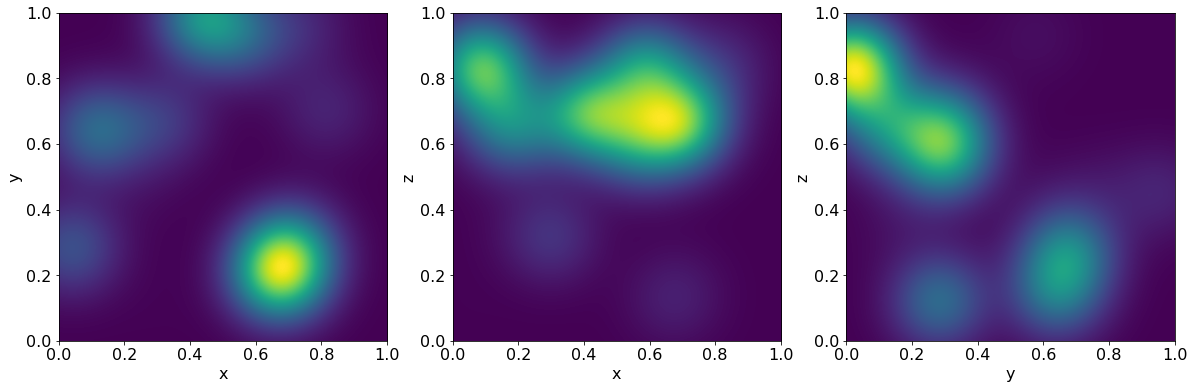

In [7]:

import numpy as np
import numba

SY=nsources

@numba.njit(parallel=True)
def rbf_evaluation(sources, targets, weights, result):
    """Evaluate the RBF sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)
  

nblocks = (targets.shape[0] + SX - 1) // SX
result_numba = np.zeros(len(targets), dtype=np.float32)
with Timer() as t:
    rbf_evaluation(sources, targets, weights, result_numba )
print('execution time of numba version:',t.interval,'s')

visualize(result_numba, npoints)

#compare the results of both implimentation
error=np.linalg.norm(result - result_numba, np.inf) / np.linalg.norm(result_numba, np.inf)
print('Error:{0}'.format(error))

Finally we experiment with how many sources and targets we can evaluate in a reasonable time (around a few seconds of runtime). The result is about 2500 points (8750000 tartgets) and 2500 sources  

transfer from the CPU to the GPU time:  0.11736464500427246 s
execution time:  3.4745962619781494 s
transfer back time:  0.03505206108093262 s


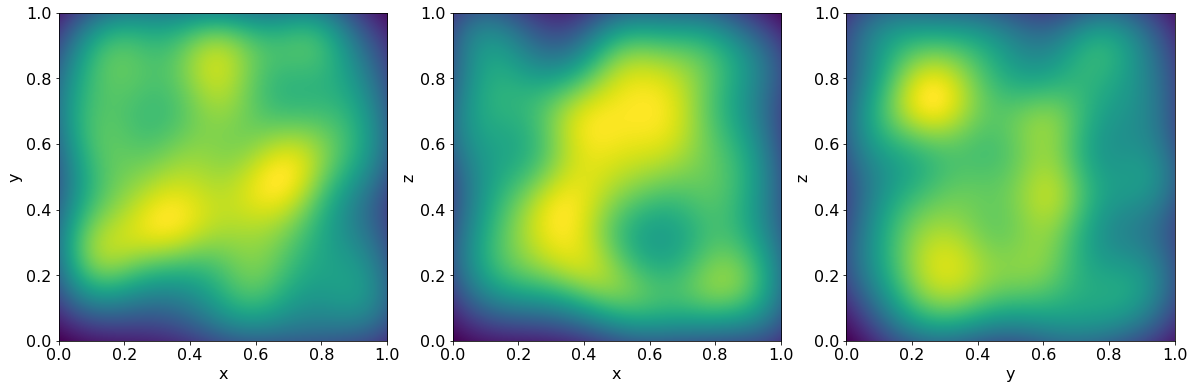

In [8]:
npoints =2500
nsources= 2500 # sources n

# generate targets,sources,weights and transfer these data to device
targets,sources,weights=data_generator(npoints,nsources)
# compute blocks per grid
l=(targets.shape[0]+SX-1)//SX
p=(nsources+SY-1)//SY

# memory transfers from the CPU to the GPU
with Timer() as t:
    device_targets=numba.cuda.to_device(targets.astype('float32'))
    device_sources=numba.cuda.to_device(sources.astype('float32'))
    device_interm_result = numba.cuda.device_array((targets.shape[0],p), dtype=np.float32) #intermediate array of size (m, p).
    device_result=numba.cuda.device_array(targets.shape[0], dtype=np.float32) 
print('transfer from the CPU to the GPU time: ', t.interval,'s')

#compute
with Timer() as t:
    rbf_evaluation_cuda[(l, p), (SX, SY)](device_sources, device_targets, weights, device_interm_result)
    summation_kernel[(l,1),(SX,1)](device_interm_result,device_result)
print("execution time: ", t.interval,'s')

#memory transfers from the GPU back to the cpu
with Timer() as t:
    result=device_result.copy_to_host() 
print("transfer back time: ", t.interval,'s')

# visulize the result
visualize(result, npoints)

## Part 2 (Evaluating the discrete Laplacian on GPUs)
- In this part we are need to create a GPU kernel, which given a one-dimensional array of values `𝑢𝑖,𝑗` in the unit square grid, and evaluates this discrete Laplace operator without explicity creatiing a matrix.
- We will create a grid of `(xblocks,yblocks)` thread blocks with `xblocks=(N+31)/32` and `yblocks=(N+31)/32` threads, so there will be N^2 threads in total.
- Each thread checks elements in `𝑢𝑖,𝑗` if its associated with a boundary value or an interior value. If it is associated with a boundary value, just write the corresponding 𝑢𝑖,𝑗 value in the result array . If it is associated with an interior point, we will use the following approximation(according to the course notes) to evaluate the value of corresponding interior point and write it into the result array. 
$-\Delta u_{i,j} ≈ \frac{4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j+1}}{h^2}$

In [9]:
import numpy as np
import numba
from numba import cuda
import math


# size of threadblocks
SX=32
SY=32

@cuda.jit
def evaluating_discrete_laplacian(x,device_result):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    px, py = cuda.grid(2)

    if px>=N or py >=N:
        return
    #associated with a boundary value
    if px==0 or px==N-1 or py==0 or py==N-1:
        x[px*N+py]=x[px*N+py]

    #associated with an interior value
    else:
        device_result[px*N+py]=(4*x[px*N+py]-x[(px-1)*N+py]-x[(px+1)*N+py]-x[px*N+py+1]-x[px*N+py-1])*(N-1)**2
  

Using function `discretise_poisson` to create the matrix A we needed to validate our result.

In [10]:
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):  
            # associated with a boundary value 
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
            # associated with an interior value    
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

- Evaluate the discrete Laplace operator and validate our code with matrix A.
- Inorder to compute the ratio of data movements to computations in our code, we need to record the time for data transformation and computation, and use ration of data transformation time and computation time to show the ratio of data movements to computations.

In [11]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [12]:
N = 1500

# compute blocks per grid
xblocks=(N+SX-1)//SX
yblocks=(N+SY-1)//SY

rand = np.random.RandomState(0)

# 𝑢(𝑖,𝑗)= 𝑥(𝑗𝑁+𝑖)
x = rand.randn(N * N)

with Timer() as t_trans_GPU:    
    # memory transfers from the CPU to the GPU
    device_x=cuda.to_device(x)
    device_result=cuda.device_array(N * N)
print('transform data to GPU time is: {0}'.format(t_trans_GPU.interval))

with Timer() as t_compute:
    # evaluates the discrete Laplace operator without explicity creatiing a matrix
    evaluating_discrete_laplacian[(xblocks,yblocks),(SX,SY)](device_x,device_result)
print('computation time is: {0}'.format(t_compute.interval))

with Timer() as t_trans_CPU:
    result=device_result.copy_to_host()
print('transform data back to CPU time is: {0}'.format(t_trans_CPU.interval))

#Validate your code against the matrix vector multiplication with the matrix created in the discrete_poisson function.
A, _ = discretise_poisson(N)

# Compare with the Scipy sparse matrix multiplication
y_exact = A @ x
rel_error = np.linalg.norm(result - y_exact, np.inf) / np.linalg.norm(y_exact, np.inf)
print(f"Error: {round(rel_error, 2)}.")

ratio=(t_trans_GPU.interval+t_trans_CPU.interval)/t_compute.interval
print('The ratio of data movements to computations is: {0}'.format(ratio))

transform data to GPU time is: 0.0050296783447265625
computation time is: 0.26181483268737793
transform data back to CPU time is: 0.004713773727416992
Error: 0.0.
The ratio of data movements to computations is: 0.03721504993484384


Then we will benchmark our code for growing matrix sizes N. Because when N reaches 1500, it will take us a few seconds to run the code, we take N_max=1500 so that we can evaluate in a reasonable time.

In [13]:
import gc
N=1500
# compute blocks per grid
xblocks=(N+SX-1)//SX
yblocks=(N+SY-1)//SY
rand = np.random.RandomState(0)

# 𝑢(𝑖,𝑗)= 𝑥(𝑗𝑁+𝑖)
x = rand.randn(N * N)

# memory transfers from the CPU to the GPU
c=cuda.to_device(x)
device_result=cuda.device_array(N * N,dtype=np.float32)


# evaluates the discrete Laplace operator without explicity creatiing a matrix
evaluating_discrete_laplacian[(xblocks,yblocks),(SX,SY)](device_x,device_result)
result=device_result.copy_to_host()

# Validate your code against the matrix vector multiplication with the matrix created in the discrete_poisson function.
A, _ = discretise_poisson(N)

# Compare with the Scipy sparse matrix multiplication
y_exact = A @ x
rel_error = np.linalg.norm(result - y_exact, np.inf) / np.linalg.norm(y_exact, np.inf)
print('N quals {0}'.format(N))
print(f"Error: {round(rel_error, 2)}.")

gc.collect()
del x,device_x,device_result,result

N quals 1500
Error: 0.0.
